# Cisco - Ariel University API Security Detection Challenge 2023
## Label 2 code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

dataset_number = 2
test_type = 'label'

# Read the json and read it to a pandas dataframe object
with open(f'./datasets/dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.Attack_Tag,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
from urllib.parse import urlparse

# Extracts the path from the url
def url_path(row):
    parsed = urlparse(row["request.url"])
    return parsed.path

# Extracts the queries from the url
def url_query(row):
    parsed = urlparse(row["request.url"])
    return parsed.query

# Extracts the length of the url
def url_len(row):
    return len(row["request.url"])

# Checks if any of the suspected headers contains a dollar sign
def has_dollarsign(row):
    if "$" in row["request.headers.Accept-Encoding"]:
        return True
    elif "$" in row["request.headers.Sec-Fetch-Site"]:
        return True
    elif "$" in row["request.headers.Sec-Fetch-Dest"]:
        return True
    elif "$" in row["request.headers.Set-Cookie"]:
        return True
    return False

# Checks if the url path contains a double dot symbolized by ".."
def has_double_dot(row):
    if ".." in row["url_path"]:
        return True
    return False

# Checks if the url path contains a double underscore symbolized by "__"
def has_double_underscore(row):
    if "__" in row["url_path"]:
        return True
    return False
    

In [3]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# make new columns for the features
df['url_length'] = df.apply(lambda row: url_len(row), axis=1)
df["url_path"] = df.apply(lambda row: url_path(row), axis=1)
df["url_query"] = df.apply(lambda row: url_query(row), axis=1)
df["has_dollarsign"] = df.apply(lambda row: has_dollarsign(row), axis=1)
df["has_doubledot"] = df.apply(lambda row: has_double_dot(row), axis=1)
df["has_doubleUnderScore"] = df.apply(lambda row: has_double_underscore(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)
df.drop('request.url', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label,url_length,url_path,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,Benign,Benign,46,/static/download_txt/7115,,False,False,False
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,Benign,Benign,39,/about/random_page,,False,False,False
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign,42,/categories/check/all,,False,False,False
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,Benign,Benign,33,/states/5911,,False,False,False
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,Benign,Benign,47,/orders/get/ship_via/10642,,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=ubWnuAa4wIHnDTz0Su8AYWJAM7fUMCps6AxyNzFok...,"Fri, 11 Nov 2022 02:57:49 GMT",GET,,404 NOT FOUND,application/json,39,404,"{""error"": ""Employee ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign,49,/orders/get/employee_id/5482,,False,False,False
127496,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=SkLWkaUE83sP38c3kf-XYBCKlSlSmBTQSEJw6EaMg...,"Fri, 11 Nov 2022 02:56:21 GMT",GET,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign,31,/post/new/,,False,False,False
127497,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=giYaDJkC2Oa-rCmlAvYglQzy_Em-YHTv_5aOjposX...,"Fri, 11 Nov 2022 02:49:37 GMT",GET,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign,31,/post/new/,,False,False,False
127498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,kee

In [4]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna('None')
    
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label,url_length,url_path,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",None,None,None,None,Benign,Benign,46,/static/download_txt/7115,,False,False,False
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",None,None,None,None,Benign,Benign,39,/about/random_page,,False,False,False
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign,42,/categories/check/all,,False,False,False
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",None,None,None,None,Benign,Benign,33,/states/5911,,False,False,False
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",None,None,None,None,Benign,Benign,47,/orders/get/ship_via/10642,,False,False,False


In [5]:
# This is a list of the headers that we want to remove from our model
COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date', 
                    "request.headers.Sec-Fetch-Dest", 
                    "request.headers.Connection", 
                    "request.headers.Accept", 
                    "request.headers.Sec-Fetch-User",
                    "request.headers.Host",
                    "response.headers.Set-Cookie", 
                    "response.status"]

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()

    # Run LabelEncoder on the chosen features
    for column in df.columns.to_list(): 
        df[column] = le.fit_transform(df[column])
    
    # Remove some columns that may be needed for the model
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Set-Cookie,request.method,response.headers.Content-Type,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,attack_type,label,url_length,url_path,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore
0,11,0,1,0,0,114274,0,0,4,4763,1,0,1,0,0,16,63762,0,0,0,0
1,28,0,3,0,0,76089,0,1,0,8,1,0,1,0,0,9,2,0,0,0,0
2,16,0,1,0,1,53628,0,0,0,4415,1,0,1,0,0,12,3,0,0,0,0
3,2,0,2,0,0,54311,0,0,4,4768,1,0,1,0,0,4,54575,0,0,0,0
4,17,0,3,0,1,26779,0,0,4,4767,1,0,1,0,0,17,47976,0,0,0,0


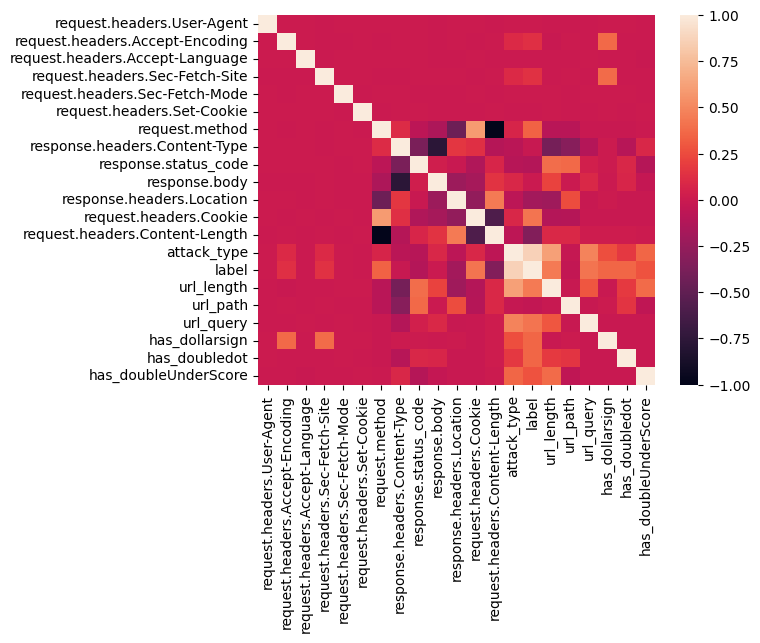

In [6]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False)

In [7]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127500 entries, 0 to 127499
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   request.headers.User-Agent       127500 non-null  int64
 1   request.headers.Accept-Encoding  127500 non-null  int64
 2   request.headers.Accept-Language  127500 non-null  int64
 3   request.headers.Sec-Fetch-Site   127500 non-null  int64
 4   request.headers.Sec-Fetch-Mode   127500 non-null  int64
 5   request.headers.Set-Cookie       127500 non-null  int64
 6   request.method                   127500 non-null  int64
 7   response.headers.Content-Type    127500 non-null  int64
 8   response.status_code             127500 non-null  int64
 9   response.body                    127500 non-null  int64
 10  response.headers.Location        127500 non-null  int64
 11  request.headers.Cookie           127500 non-null  int64
 12  request.headers.Content-Length

In [8]:
# Choose the right features
# In our example code we choose all the columns as our feature

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Set-Cookie', 'request.method', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'url_length', 'url_path', 'url_query', 'has_dollarsign', 'has_doubledot', 'has_doubleUnderScore']


request.headers.User-Agent         int64
request.headers.Accept-Encoding    int64
request.headers.Accept-Language    int64
request.headers.Sec-Fetch-Site     int64
request.headers.Sec-Fetch-Mode     int64
request.headers.Set-Cookie         int64
request.method                     int64
response.headers.Content-Type      int64
response.status_code               int64
response.body                      int64
response.headers.Location          int64
request.headers.Cookie             int64
request.headers.Content-Length     int64
attack_type                        int64
label                              int64
url_length                         int64
url_path                           int64
url_query                          int64
has_dollarsign                     int64
has_doubledot                      int64
has_doubleUnderScore               int64
dtype: object

## Train test split

In [9]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing RandomForest model
# X_Train and y_Train will be used for training
# X_test and y_test will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(104996, 19) (104996,)
(22504, 19) (22504,)


Counter({0: 117914, 1: 9586})

## Model choosing and fitting

In [10]:
# We train the model on the training data
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))


[(0, 97102), (1, 7894)]


## Result printout

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000     20812
           1    1.00000   1.00000   1.00000      1692

    accuracy                        1.00000     22504
   macro avg    1.00000   1.00000   1.00000     22504
weighted avg    1.00000   1.00000   1.00000     22504



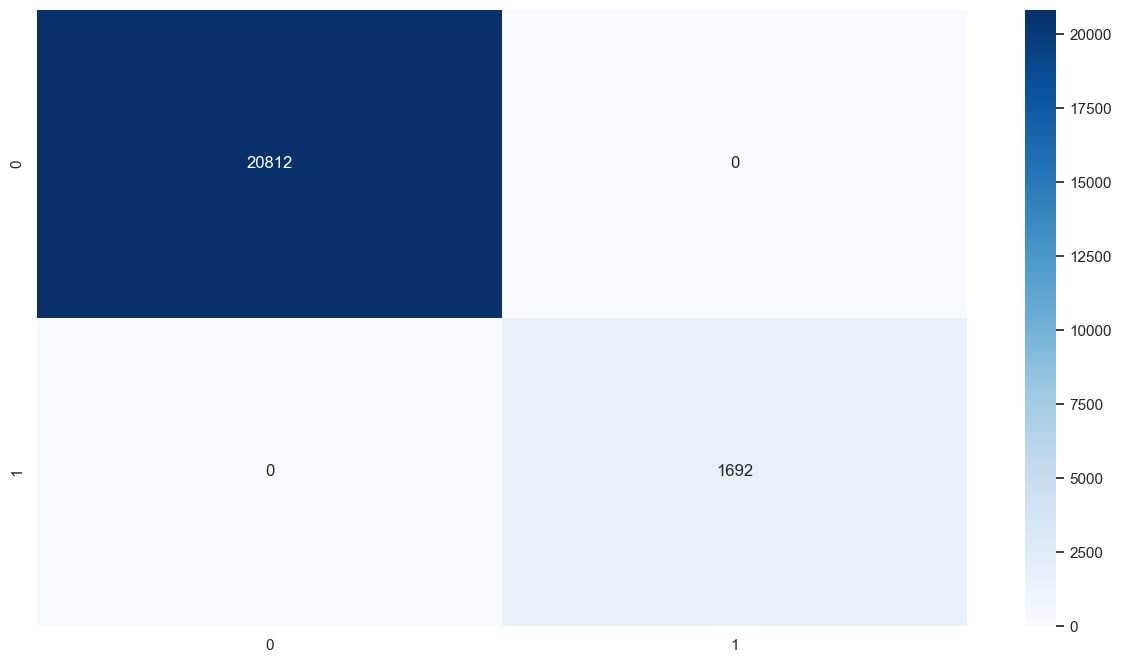

In [11]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})

predictions = clf.predict(X_test)

true_labels = y_test
clf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(clf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [12]:
# Read the valuation json, preprocess it and run the model 
with open(f'./datasets/dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset
test_df['url_length'] = test_df.apply(lambda row: url_len(row), axis=1)
test_df["url_path"] = test_df.apply(lambda row: url_path(row), axis=1)
test_df["url_query"] = test_df.apply(lambda row: url_query(row), axis=1)
test_df["has_dollarsign"] = test_df.apply(lambda row: has_dollarsign(row), axis=1)
test_df["has_doubledot"] = test_df.apply(lambda row: has_double_dot(row), axis=1)
test_df["has_doubleUnderScore"] = test_df.apply(lambda row: has_double_underscore(row), axis=1)
for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)

# Predict with the model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)

# Save your predictions

In [13]:
# Save the preditions
enc = LabelEncoder()
np.savetxt(f'./datasets/dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')